# Spacecraft with reaction wheels and star tracker

Import modules and configure the notebook.

In [110]:
# Standard modules
import time
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy import linalg

# My own script (an interface to the simulator)
import ae353_spacecraft

## Dynamic model

Specify the physical parameters:

In [111]:
# Mass and MOI of base
mb = 6.
Jxb = 10.
Jyb = 10.
Jzb = 16.

# Mass and MOI of each wheel
mw = 1.
Jxw = 0.075
Jyw = 0.075
Jzw = 0.125
lw = 1.1

Derive the equations of motion:

In [112]:
# Define yaw, pitch, roll yaw angles
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# Define torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# Compute resultant torques
lt = sym.nsimplify(lw) * sym.sqrt(2) / 2
T1 = - tau_1 * sym.Matrix([[lt], [0], [lt]])
T2 = - tau_2 * sym.Matrix([[-lt], [0], [lt]])
T3 = - tau_3 * sym.Matrix([[0], [lt], [lt]])
T4 = - tau_4 * sym.Matrix([[0], [-lt], [lt]])
T = T1 + T2 + T3 + T4

# Define MOI of spacecraft and wheels together
Jx = sym.nsimplify(Jxb + 4 * mw * lw**2)
Jy = sym.nsimplify(Jyb + 4 * mw * lw**2)
Jz = sym.nsimplify(Jzb + 4 * mw * lw**2)

# Define rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define euler's equations
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                   [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                   [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# Define equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

The equations of motion have this form:

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{w_x} \\ \dot{w_y} \\ \dot{w_z} \end{bmatrix} = f\left(\psi, \theta, \phi, w_x, w_y, w_z, \tau_1, \tau_2, \tau_3, \tau_4\right)$$

Here is the function $f$:

In [113]:
f

Matrix([
[                        (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                     w_y*cos(phi) - w_z*sin(phi)],
[         w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[-55*sqrt(2)*tau_1/1484 + 55*sqrt(2)*tau_2/1484 - 150*w_y*w_z/371],
[-55*sqrt(2)*tau_3/1484 + 55*sqrt(2)*tau_4/1484 + 150*w_x*w_z/371],
[                -55*sqrt(2)*(tau_1 + tau_2 + tau_3 + tau_4)/2084]])

In [114]:
f_num = sym.lambdify((psi, theta, phi, w_x, w_y, w_z,tau_1, tau_2, tau_3, tau_4),f)


Set equilibrium values

In [115]:
psi_e = 0
theta_e = 0
phi_e = 0
w_x_e = 0
w_y_e = 0
w_z_e = 0
tau_1_e = 0
tau_2_e = 0
tau_3_e = 0
tau_4_e = 0

Check equilibrium values

In [116]:
print(f_num(psi_e, theta_e, phi_e, w_x_e, w_y_e, w_z_e, tau_1_e, tau_2_e, tau_3_e, tau_4_e))

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-0.]]


Set up A and B matrices

In [117]:
A_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4], f.jacobian([psi, theta, phi, w_x, w_y, w_z]))
A = A_num(psi_e, theta_e, phi_e, w_x_e, w_y_e, w_z_e, tau_1_e, tau_2_e, tau_3_e, tau_4_e)

B_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4], f.jacobian([tau_1, tau_2, tau_3, tau_4]))
B = B_num(psi_e, theta_e, phi_e, w_x_e, w_y_e, w_z_e, tau_1_e, tau_2_e, tau_3_e, tau_4_e)

print('A: ', A.tolist())
print('B: ', B.tolist())

A:  [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 1.0, -0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, -0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
B:  [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [-0.052413575424878865, 0.052413575424878865, 0.0, 0.0], [0.0, 0.0, -0.052413575424878865, 0.052413575424878865], [-0.03732329459238015, -0.03732329459238015, -0.03732329459238015, -0.03732329459238015]]


Check controllability

In [118]:
n = A.shape[0]

W = B

for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])

r = np.linalg.matrix_rank(W)
print('W Matrix:')
print(W)
print('Rank:')
print(r)

W Matrix:
[[ 0.          0.          0.          0.         -0.03732329 -0.03732329
  -0.03732329 -0.03732329  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -0.05241358  0.05241358  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -0.05241358  0.05241358
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [-0.05241358  0.05241358  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.      

## Sensor model

Symbolic variables for right ascension $\alpha$ and declination $\delta$ of each star:

In [119]:
alpha, delta = sym.symbols('alpha, delta')

Specify the physical parameters:

In [120]:
# Scope radius
r = 0.8 / 2.1

Derive the sensor model:

In [121]:
# Position of star in space frame
p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                              [sym.sin(alpha) * sym.cos(delta)],
                              [sym.sin(delta)]])

# Orientation of body frame in space frame
R_body_in_space = Rz * Ry * Rx

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
p_star_in_image = (1 / sym.nsimplify(r)) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                                       [p_star_in_body[2] / p_star_in_body[0]]])

# Sensor model for each star
g = sym.simplify(p_star_in_image, full=True)

The sensor model has this form for each star:

$$\zeta = g(\psi, \theta, \phi, \alpha, \delta)$$

Here is the function $g$:

In [122]:
g

Matrix([
[21*(sin(delta)*sin(phi)*cos(theta) + sin(phi)*sin(theta)*cos(delta)*cos(alpha - psi) + sin(alpha - psi)*cos(delta)*cos(phi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))],
[21*(sin(delta)*cos(phi)*cos(theta) - sin(phi)*sin(alpha - psi)*cos(delta) + sin(theta)*cos(delta)*cos(phi)*cos(alpha - psi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))]])

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

Here are two optional arguments you may want to use:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `seed` (an integer, default `None`) is a seed to initialize the random number generator used by the simulator.

**You must evaluate this cell only *once*.** If you want to start fresh with a new simulator, you must do `Kernel -> Restart` from the notebook menu first. If you evaluate this cell more than once without a call to `Kernel -> Restart` then you may get strange behavior that is hard to debug.

In [125]:
simulator = ae353_spacecraft.Simulator(
    display=False,
    seed=None,
)

Here is how to find the location of each star:

In [126]:
for (i, star) in enumerate(simulator.stars):
    print(f'star {i} : alpha = {star["alpha"]:5.2f} : delta = {star["delta"]:5.2f}')

alpha0 = -0.10
delta0 = -0.15
alpha1 = 0.00
delta1 = -0.15
alpha2 = 0.10
delta2 = -0.15
alpha3 = 0.00
delta3 = 0.00
alpha4 = -0.10
delta4 = 0.15
alpha5 = 0.00
delta5 = 0.15
alpha6 = 0.10
delta6 = 0.15

star 0 : alpha = -0.10 : delta = -0.15
star 1 : alpha =  0.00 : delta = -0.15
star 2 : alpha =  0.10 : delta = -0.15
star 3 : alpha =  0.00 : delta =  0.00
star 4 : alpha = -0.10 : delta =  0.15
star 5 : alpha =  0.00 : delta =  0.15
star 6 : alpha =  0.10 : delta =  0.15


In [127]:
G = np.block([[g.subs([(alpha, alpha0), (delta, delta0)])],[g.subs([(alpha, alpha1), (delta, delta1)])],[g.subs([(alpha, alpha2), (delta, delta2)])],[g.subs([(alpha, alpha3), (delta, delta3)])],[g.subs([(alpha, alpha4), (delta, delta4)])], [g.subs([(alpha, alpha5), (delta, delta5)])], [g.subs([(alpha, alpha6), (delta, delta6)])]])
G = sym.Matrix(G)
G

Matrix([
[ 21*(0.988771077936042*sin(phi)*sin(theta)*cos(psi + 0.1) - 0.149438132473599*sin(phi)*cos(theta) - 0.988771077936042*sin(psi + 0.1)*cos(phi))/(8*(0.149438132473599*sin(theta) + 0.988771077936042*cos(theta)*cos(psi + 0.1)))],
[ 21*(0.988771077936042*sin(phi)*sin(psi + 0.1) + 0.988771077936042*sin(theta)*cos(phi)*cos(psi + 0.1) - 0.149438132473599*cos(phi)*cos(theta))/(8*(0.149438132473599*sin(theta) + 0.988771077936042*cos(theta)*cos(psi + 0.1)))],
[                   21*(0.988771077936042*sin(phi)*sin(theta)*cos(psi) - 0.149438132473599*sin(phi)*cos(theta) - 0.988771077936042*sin(psi)*cos(phi))/(8*(0.149438132473599*sin(theta) + 0.988771077936042*cos(psi)*cos(theta)))],
[                   21*(0.988771077936042*sin(phi)*sin(psi) + 0.988771077936042*sin(theta)*cos(phi)*cos(psi) - 0.149438132473599*cos(phi)*cos(theta))/(8*(0.149438132473599*sin(theta) + 0.988771077936042*cos(psi)*cos(theta)))],
[ 21*(0.988771077936042*sin(phi)*sin(theta)*cos(psi - 0.1) - 0.149438132473599*sin(

In [128]:
G_num = sym.lambdify((psi, theta, phi), G)
Geq = G_num(psi_e, theta_e, phi_e)
Geq

array([[-0.26337851],
       [-0.3987219 ],
       [ 0.        ],
       [-0.39672995],
       [ 0.26337851],
       [-0.3987219 ],
       [ 0.        ],
       [ 0.        ],
       [-0.26337851],
       [ 0.3987219 ],
       [ 0.        ],
       [ 0.39672995],
       [ 0.26337851],
       [ 0.3987219 ]])

In [129]:
Q = np.diag([5.,1.,1.,0.1,0.4,0.4])
R = np.eye(4)/5
P = linalg.solve_continuous_are(A, B, Q, R)
K = linalg.inv(R) @  B.T @ P
K
linalg.eigvals(A - B @ K)


array([-0.43520401+0.42875449j, -0.43520401-0.42875449j,
       -0.28906735+0.28668161j, -0.28906735-0.28668161j,
       -0.2926095 +0.28306529j, -0.2926095 -0.28306529j])

In [130]:
C_num = sym.lambdify((psi, theta, phi), G.jacobian([psi, theta, phi, w_x, w_y, w_z]))
C = C_num(psi_e, theta_e, phi_e)
C

array([[-2.651426  ,  0.04000563, -0.3987219 ,  0.        ,  0.        ,
         0.        ],
       [-0.04000563,  2.68556349,  0.26337851,  0.        ,  0.        ,
         0.        ],
       [-2.625     ,  0.        , -0.39672995,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  2.68495987,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-2.651426  , -0.04000563, -0.3987219 ,  0.        ,  0.        ,
         0.        ],
       [ 0.04000563,  2.68556349, -0.26337851,  0.        ,  0.        ,
         0.        ],
       [-2.625     ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  2.625     ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-2.651426  , -0.04000563,  0.3987219 ,  0.        ,  0.        ,
         0.        ],
       [ 0.04000563,  2.68556349,  0.26337851,  0.        ,  0.        ,
         0.        ],
       [-2.625     ,  0.        ,  0.39672995,  0.

In [131]:
Wo = C
for i in range(1,n):
    row = C @ np.linalg.matrix_power(A,i)
    Wo = np.block([[Wo],[row]])
rank = np.linalg.matrix_rank(Wo)
print(rank)

6


In [132]:
# Qo1 = np.diag(np.ones(2*5)) # (2n)x(2n) for an n star system
# Ro1 = 0.05*np.diag([1.,1.,1.,1.,1.,1.])

Qo = np.eye(A.shape[0])*5
Ro = np.eye(C.shape[0])*0.5
print(Qo)

P = linalg.solve_continuous_are(A.T, C.T, linalg.inv(Qo), linalg.inv(Ro)).T
L = (linalg.inv(Ro) @  C @ P).T
L
print(L.shape)
L.shape
Geq.shape

[[5. 0. 0. 0. 0. 0.]
 [0. 5. 0. 0. 0. 0.]
 [0. 0. 5. 0. 0. 0.]
 [0. 0. 0. 5. 0. 0.]
 [0. 0. 0. 0. 5. 0.]
 [0. 0. 0. 0. 0. 5.]]
(6, 14)


(14, 1)

Define a controller that maps sensor measurements to actuator commands. By default, it applies zero torque to each reaction wheel. Modify the `run` function to make the controller behave differently.

In [133]:
class Controller:
    def __init__(self):
        self.dt = 0.01
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L =  L
        self.Geq = Geq.flatten()
        self.psi_e = 0
        self.theta_e = 0
        self.phi_e = 0
        self.w_x_e = 0
        self.w_y_e = 0
        self.w_z_e = 0
        self.tau_1_e = 0
        self.tau_2_e = 0
        self.tau_3_e = 0
        self.tau_4_e = 0
        pass
    
    def reset(self):
        self.xhat = np.zeros((6,1))
    
    def run(self, t, star_meas):
        """
        star_meas is a 1d array of length 14 - the image coordinates
        y_i and z_i of the i'th star (for i = 0, ..., 6) are at index
        2*i and 2*i+1 of this array, respectively
        """
        
        # FIXME: replace the following lines
        u = - self.K @ self.xhat
        #print(u)
        front_torque = (u +self.tau_1_e)[0][0]
        back_torque = (u +self.tau_2_e)[1][0]
        left_torque = (u +self.tau_3_e)[2][0]
        right_torque = (u +self.tau_4_e)[3][0]
        
        #y = np.array([self.Geq - star_meas])
        y = np.array([star_meas-self.Geq.astype(float)])
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C@self.xhat  - y.T))
        
        return front_torque, back_torque, left_torque, right_torque

Create an instance of the controller.

In [134]:
controller = Controller()

You could reset the simulator with given initial conditions, optionally specifying scope noise (default is `0.1`), i.e., the standard deviation of the $y$ and $z$ components of each star tracker measurement.

In [135]:
simulator.reset(
    orientation={
        'yaw': 0.,
        'pitch': 0.,
        'roll': 0.,
    },
    angular_velocity={
        'x': 0.,
        'y': 0.,
        'z': 0.,
    },
    scope_noise=0.1,
)

Or, you could reset the simulator with initial conditions sampled at random.

In [136]:
simulator.reset(
    orientation=None,
    angular_velocity=None,
    scope_noise=0.1,
)

Reset the controller.

In [137]:
controller.reset()

Run the simulator. It will quit when one of the following conditions is satisfied:

* Any star goes out of view of the scope.
* Any reaction wheel has angular velocity exceeding +/- 50 rad/s.
* The maximum time is reached.

In [138]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=30.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
)

In [139]:
run_times = []
while len(run_times) <= 1000:
    simulator.reset(
        orientation={
        'yaw': 0.,
        'pitch': 0.,
        'roll': 0.,
        },
        angular_velocity={
            'x': 0.,
            'y': 0.,
            'z': 0.,
        },
        scope_noise=0.1,
    )
    simulator.reset(
        orientation=None,
        angular_velocity=None,
        scope_noise=0.1,
    )
    
    controller.reset()
    
    data = simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=30.0,         # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
        print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
    )
    
    run_time = data['t'][-1]
    run_times.append(run_time)
    
    
    

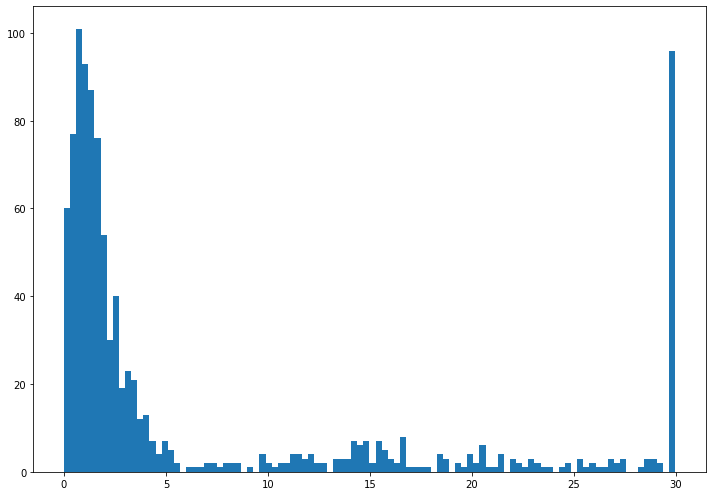

In [142]:
import statistics as stat
from matplotlib import pyplot as plt

av_time = sum(run_times)/1000
st_dev = stat.stdev(run_times)

fig, axs = plt.subplots(1, 1, figsize=(10, 7), tight_layout=True)

axs.hist(run_times, 100)

plt.show()

Get, show, and save a snapshot of the simulation after the last time step.

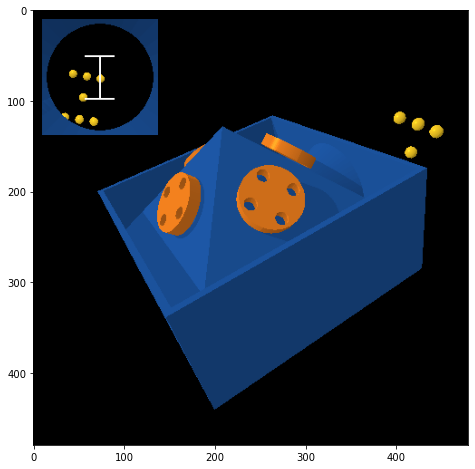

In [105]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

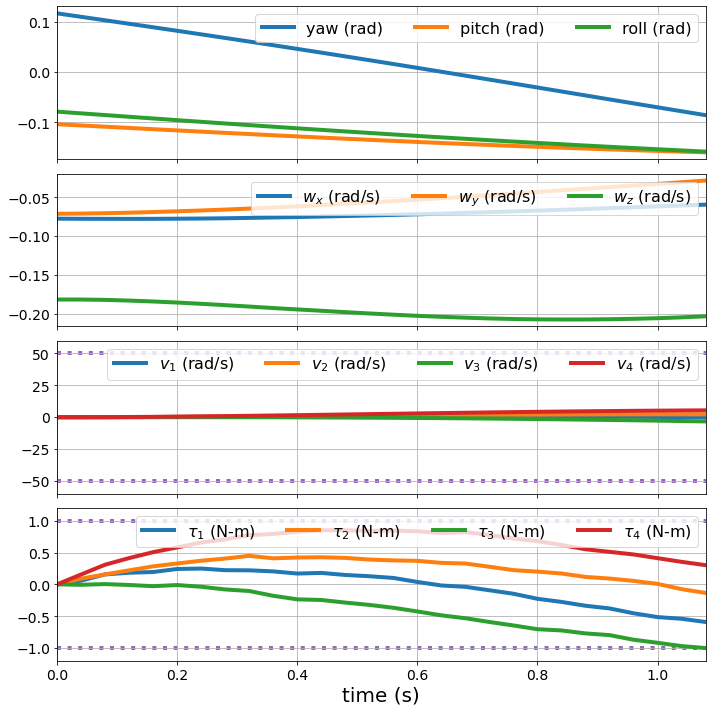

In [106]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_ori, ax_vel, ax_rwvel, ax_rwtau) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Plot yaw, pitch, roll angles
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=4)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=4)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=4)
ax_ori.grid()
ax_ori.legend(fontsize=16, ncol=3, loc='upper right')
ax_ori.tick_params(labelsize=14)

# Plot x, y, z components of angular velocity
ax_vel.plot(data['t'], data['w_x'], label=r'$w_x$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_y'], label=r'$w_y$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_z'], label=r'$w_z$ (rad/s)', linewidth=4)
ax_vel.grid()
ax_vel.legend(fontsize=16, ncol=3, loc='upper right')
ax_vel.tick_params(labelsize=14)

# Plot angular velocity of each reaction wheel
ax_rwvel.plot(data['t'], data['front_velocity'], label=r'$v_1$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['back_velocity'], label=r'$v_2$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['left_velocity'], label=r'$v_3$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['right_velocity'], label=r'$v_4$ (rad/s)', linewidth=4)
ax_rwvel.plot(
    data['t'], np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.plot(
    data['t'], -np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.grid()
ax_rwvel.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwvel.tick_params(labelsize=14)
ax_rwvel.set_ylim(-1.2 * simulator.v_max, 1.2 * simulator.v_max)

# Plot torque applied to each reaction wheel
ax_rwtau.plot(data['t'], data['front_torque'], label=r'$\tau_1$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['back_torque'], label=r'$\tau_2$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['left_torque'], label=r'$\tau_3$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['right_torque'], label=r'$\tau_4$ (N-m)', linewidth=4)
ax_rwtau.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.grid()
ax_rwtau.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwtau.tick_params(labelsize=14)


# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_rwtau.set_xlabel('time (s)', fontsize=20)
ax_rwtau.set_xlim([data['t'][0], data['t'][-1]])
ax_rwtau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [107]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

Plot star positions in image. This is not necessarily a useful thing to plot. The point is to show how to access measurements of star position from logged data.

(-1.0, 1.0)

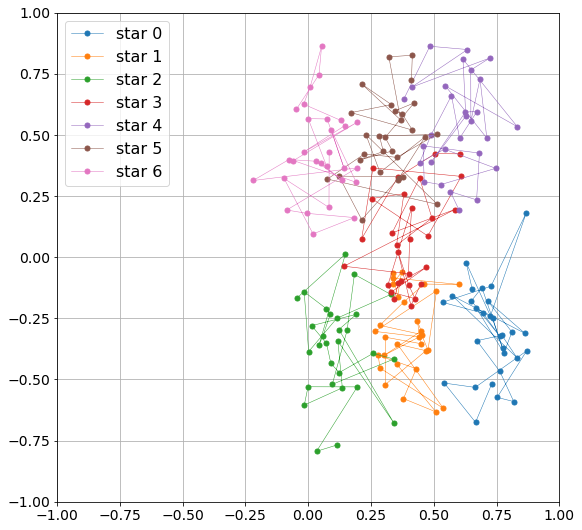

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
for i in range(len(simulator.stars)):
    y = data['star_meas'][:, 2 * i]
    z = data['star_meas'][:, 2 * i + 1]
    ax.plot(-y, z, label=f'star {i}', linewidth=0.5, marker='.', markersize=10)
ax.grid()
ax.legend(fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xlim(-1., 1.)
ax.set_ylim(-1., 1.)